# Bio-BERT Transformer Trainer


## Set Up

In [1]:
# !pip install transformers datasets accelerate evaluate

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [1]:
# cd drive/MyDrive/w210_Capstone/
%cd ..

/home/ubuntu/capstone-project


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, AutoConfig
from transformers import AdamW, get_cosine_schedule_with_warmup
from transformers import BertConfig, BertModel
from datasets import load_metric, load_dataset

import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

# from logging import warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():
    device = "cuda"
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = "cpu"

Number of GPU(s) available: 1
GPU device name: NVIDIA A10G


In [4]:
from huggingface_hub import notebook_login

notebook_login()

## Training Bio-BERT with Trainer & Hugging Face

### Build DataSet

In [5]:
## Define hyperparameters
BATCH_SIZE = 128
EPOCHS = 2
LEARNING_RATE = 6.28e-4
# LEARNING_RATE = 0.0963
# WEIGHT_DECAY = 1e-4
WEIGHT_DECAY = 0.1
WORKERS = int(os.cpu_count())

In [6]:
# Import data
train_file = 'data/binary_ddi/ddi_train_balanced_150k.csv'
dev_file = 'data/binary_ddi/ddi_val_binary.csv'
test_file = 'data/binary_ddi/ddi_test_binary.csv'

dataset = load_dataset('csv',
                       sep="\t",
                       data_files={'train': train_file, 'validation': dev_file,'test': test_file})

Found cached dataset csv (/home/ubuntu/.cache/huggingface/datasets/csv/default-7c7fda65b4fd85b3/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity', 'smiles1', 'smiles2'],
        num_rows: 300000
    })
    validation: Dataset({
        features: ['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity', 'smiles1', 'smiles2'],
        num_rows: 238072
    })
    test: Dataset({
        features: ['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity', 'smiles1', 'smiles2'],
        num_rows: 186753
    })
})

In [10]:
df_train = pd.read_csv(train_file, sep='\t')
df_dev = pd.read_csv(dev_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')
print(f'''mean length of smiles1: {df_train['smiles1'].map(len).mean()}''')
print(f'''min length of smiles1: {df_train['smiles1'].map(len).min()}''')
print(f'''max length of smiles1: {df_train['smiles1'].map(len).max()}''')
print(f'''mean length of smiles2: {df_train['smiles2'].map(len).mean()}''')
print(f'''min length of smiles2: {df_train['smiles2'].map(len).min()}''')
print(f'''max length of smiles2: {df_train['smiles2'].map(len).max()}''')
print('Value Counts of Labels in Train Set:')
df_train.interaction_type.value_counts()

mean length of smiles1: 62.479706666666665
min length of smiles1: 2
max length of smiles1: 748
mean length of smiles2: 62.77145
min length of smiles2: 3
max length of smiles2: 748
Value Counts of Labels in Train Set:


interaction_type
1    150000
0    150000
Name: count, dtype: int64

In [8]:
## Load the pre-trained BioBERT tokenizer
# model_checkpoint = "dmis-lab/biobert-base-cased-v1.1"
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"

# Tokenize & Pre-process Data
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [9]:
from transformers import PretrainedConfig

class BioClinicalBertConfig(PretrainedConfig):
    model_type = "bert"
    def __init__(
            self,
            hidden_size1: int = 68,
            hidden_size2: int = 54,
            hidden_size3: int = 40,
            hidden3_dropout: float = 0.1,
            unfreeze: bool = False,
            layer_norm_eps: float = 1e-12,
            pad_token_id: int = 0,
            position_embedding_type: str = "absolute",
            use_cache: bool = True,
            **kwargs,
    ):
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.hidden3_dropout = hidden3_dropout
        self.unfreeze = unfreeze
        self.layer_norm_eps = layer_norm_eps
        self.pad_token_id = pad_token_id
        self.position_embedding_type = position_embedding_type
        self.use_cache = use_cache
        super().__init__(**kwargs)

config = BioClinicalBertConfig.from_pretrained(
    model_checkpoint,
)

In [10]:
print(config)

BioClinicalBertConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden3_dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "hidden_size1": 68,
  "hidden_size2": 54,
  "hidden_size3": 40,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "unfreeze": false,
  "use_cache": true,
  "vocab_size": 28996
}



In [11]:
# Create Combined SMILES column, seperated by [SEP] token between SMILES1 & SMILES2
def preprocess_data(examples):
    source_inputs = []
    for sm1, sm2 in zip(examples['smiles1'], examples['smiles2']):
        # Ensure feeding both smile 1 & smiles 2 into input by truncating if the smiles are too loong
        source_input = "[CLS]" + sm1[:250] + "[SEP]" + sm2[:250] + "[SEP]"
        source_inputs.append(source_input)
    model_inputs = tokenizer(source_inputs,
                             max_length=512,
                             padding="max_length",
                             truncation=True,
                             return_token_type_ids=False,
                             return_tensors='pt'
                             )

    model_inputs["labels"] = examples['interaction_type']

    return model_inputs

In [12]:
encoded_train_ds = dataset['train'].map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)
encoded_val_ds_full = dataset['validation'].map(preprocess_data, batched=True, remove_columns=dataset['validation'].column_names)
encoded_val_ds = encoded_val_ds_full.select(indices=range(30000))  # Subset to smaller valset for faster training
encoded_test_ds = dataset['test'].map(preprocess_data, batched=True, remove_columns=dataset['test'].column_names)

encoded_val_ds

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/csv/default-7c7fda65b4fd85b3/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-302195fe960a0721.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/csv/default-7c7fda65b4fd85b3/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-662aa695b906c621.arrow


Map:   0%|          | 0/186753 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 30000
})

In [13]:
encoded_val_ds[0]['labels']

1

In [14]:
len(encoded_train_ds)/BATCH_SIZE

2343.75

### Build Model, Set up Trainer

In [15]:
from transformers import BertPreTrainedModel, BertModel

class BioClinicalBertClassification(BertPreTrainedModel):
    config_class = BioClinicalBertConfig

    def __init__(self, config=config, num_labels=2):
        super(BioClinicalBertClassification, self).__init__(config)
        self.bert_model = BertModel(config=config)

        self.num_labels = num_labels

        # Unfreeze the last BERT transformer layer
        if config.unfreeze == "last layer":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if config.unfreeze == "all layers":
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = True
        else:
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = False

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_layer = nn.Linear(self.bert_hidden_size, config.hidden_size1)
        self.hidden_layer2 = nn.Linear(config.hidden_size1, config.hidden_size2)
        self.hidden_layer3 = nn.Linear(config.hidden_size2, config.hidden_size3)

        self.drop_out = nn.Dropout(config.hidden3_dropout)

        if self.num_labels > 2:
            self.classification = nn.Linear(config.hidden_size3, self.num_labels)
        else:
            self.classification = nn.Linear(config.hidden_size3, 1)

        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        bert_output = self.bert_model(input_ids=input_ids,
                                      attention_mask=attention_mask)

        # hidden_state = bert_output[0]
        pooler_token = bert_output[1]

        hidden_ouput = self.GeLU(self.hidden_layer(pooler_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer3(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)

        if self.num_labels > 2:
            logits = self.classification(hidden_ouput)

        else:
            logits = self.Sigmoid(self.classification(hidden_ouput))
            logits = logits.flatten()

        if self.num_labels == 2 and labels is not None:
            loss_fct = nn.BCELoss()
            loss = loss_fct(logits, labels.float())
            return {"loss": loss, "logits": logits}

        if self.num_labels > 2 and labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

In [16]:
BioClinicalBertConfig.register_for_auto_class()
BioClinicalBertClassification.register_for_auto_class("AutoModel")

In [17]:
# Load Metric
metric = load_metric('glue', 'sst2')
metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

In [18]:
# Test metric calculation
fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'accuracy': 0.484375}

In [19]:
def compute_metrics(eval_pred, num_labels=2):
    predictions, labels = eval_pred
        
    if num_labels > 2:
        # probability
        # softmax = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)
        # scores = softmax[:, 1]
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions =(np.array(predictions) >= 0.5).astype(float)
        # scores = np.array(predictions)

    # Accuracy
    result = metric.compute(predictions=predictions, references=labels)

    # Add F2 Score
    result["f2"] = metrics.fbeta_score(labels, predictions, average="binary", pos_label=1, beta=2)

    # Add Recall
    result["recall"] = metrics.recall_score(labels, predictions, average="binary", pos_label=1)

    # Add Precision
    result["precision"] = metrics.precision_score(labels, predictions, average="binary", pos_label=1)

    # Matthew Correlation
    result["mcc"] = metrics.matthews_corrcoef(labels, predictions)

    # Area Under Precision, Recall Curve
    # precisions, recalls, thresholds = precision_recall_curve(labels, scores)
    # result["AUPRC"] = auc(precisions, recalls)
    

    return {k: round(v, 4) for k, v in result.items()}

In [20]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [44]:
# Model Initilization
model = BioClinicalBertClassification(config)
# model = model.to("cpu")

# # Pretrain model weights
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"
pretrained_model = AutoModel.from_pretrained(model_checkpoint)
# # Load pre-train weights to BioBert model
model.bert_model.load_state_dict(pretrained_model.state_dict())

# Load training weights, for continue training
# pretrained_weights = torch.load('models/BioBERTFrozen.pth')
pretrained_weights = torch.load('models/BioClinicalBertFrozen.pth')
model.load_state_dict(pretrained_weights )



# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_checkpoint, config=config
# )

# Print out models params for checking
params = list(model.named_parameters())
for p in params[-30:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Optimizer & Schedular
# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, 
#                   weight_decay=WEIGHT_DECAY)
# scheduler = get_cosine_schedule_with_warmup(optimizer,
#                                             num_warmup_steps=10,
#                                             num_training_steps=30000)

# Optimizer
# optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = round(EPOCHS*len(encoded_train_ds)/BATCH_SIZE)
print('Number of steps:', T_max)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert_model.encoder.layer.10.output.dense.weight          (768, 3072)
bert_model.encoder.layer.10.output.dense.bias                 (768,)
bert_model.encoder.layer.10.output.LayerNorm.weight           (768,)
bert_model.encoder.layer.10.output.LayerNorm.bias             (768,)
bert_model.encoder.layer.11.attention.self.query.weight   (768, 768)
bert_model.encoder.layer.11.attention.self.query.bias         (768,)
bert_model.encoder.layer.11.attention.self.key.weight     (768, 768)
bert_model.encoder.layer.11.attention.self.key.bias           (768,)
bert_model.encoder.layer.11.attention.self.value.weight   (768, 768)
bert_model.encoder.layer.11.attention.self.value.bias         (768,)
bert_model.encoder.layer.11.attention.output.dense.weight   (768, 768)
bert_model.encoder.layer.11.attention.output.dense.bias       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.weight       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.bias       (768,)
bert_model.encoder.lay

### Training with Trainer

In [38]:
# Training Arguments
model_dir = "morgan-embed-bio-clinical-bert-ddi"

args = TrainingArguments(
    output_dir=model_dir,
    overwrite_output_dir=True,
    do_train=True,
    evaluation_strategy="epoch",
    # save_strategy="steps",
    # save_steps=200,
    # evaluation_strategy="steps",
    # eval_steps=200,
    # logging_strategy="steps",
    # logging_steps=200,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=1,
    num_train_epochs=EPOCHS,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=True,
    push_to_hub=True,
)

In [39]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train_ds,
    eval_dataset=encoded_val_ds,
    tokenizer=tokenizer,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
)

/home/ubuntu/capstone-project/morgan-embed-bio-clinical-bert-ddi is already a clone of https://huggingface.co/ltmai/morgan-embed-bio-clinical-bert-ddi. Make sure you pull the latest changes with `repo.git_pull()`.


In [45]:
# filename = 'models/bioclinicalbertcheckpoint.pth.tar'

# def save_checkpoint(state, filename=filename):
#     # save the model state!
#     torch.save(state, filename)

# save_checkpoint({'state_dict': model.state_dict()})

In [24]:
# Starting metrics from last checkpoint training
trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.245300054550171,
 'eval_accuracy': 0.663,
 'eval_f2': 0.7672,
 'eval_recall': 0.7967,
 'eval_precision': 0.6682,
 'eval_mcc': 0.3038,
 'eval_runtime': 255.6916,
 'eval_samples_per_second': 117.329,
 'eval_steps_per_second': 0.919}

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F2,Recall,Precision,Mcc
1,0.292200,0.992172,0.662500,0.754600,0.778100,0.673100,0.303800
2,0.291200,0.975614,0.662500,0.752600,0.775300,0.673900,0.303900


We can't save the code defining BioClinicalBertClassification(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

TrainOutput(global_step=4688, training_loss=0.2908523701156772, metrics={'train_runtime': 6519.7179, 'train_samples_per_second': 92.029, 'train_steps_per_second': 0.719, 'total_flos': 1.579711813632e+17, 'train_loss': 0.2908523701156772, 'epoch': 2.0})

### Evaluation

In [26]:
trainer.evaluate(encoded_test_ds)

{'eval_loss': 0.7759733200073242,
 'eval_accuracy': 0.7217,
 'eval_f2': 0.7929,
 'eval_recall': 0.7933,
 'eval_precision': 0.7911,
 'eval_mcc': 0.3709,
 'eval_runtime': 1593.1254,
 'eval_samples_per_second': 117.224,
 'eval_steps_per_second': 0.916,
 'epoch': 2.0}

In [40]:
trainer.push_to_hub()
#model.push_to_hub()

We can't save the code defining BioClinicalBertClassification(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

Upload file training_args.bin:   0%|          | 1.00/3.87k [00:00<?, ?B/s]

To https://huggingface.co/ltmai/morgan-embed-bio-clinical-bert-ddi
   05ac07c..d647a41  main -> main

To https://huggingface.co/ltmai/morgan-embed-bio-clinical-bert-ddi
   d647a41..a30e76d  main -> main



'https://huggingface.co/ltmai/morgan-embed-bio-clinical-bert-ddi/commit/d647a4163b22f585484084be15bc1a34d9991e27'

In [41]:
# save training weights
trainer.save_model('morgan-embed-bio-clinical-bert-ddi')
# torch.save(model.state_dict(), 'models/Bio_ClinicalBERT_DDI_finetuned_small.pth')

We can't save the code defining BioClinicalBertClassification(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## Training Manually - Frozen All Layers

### Build Model

In [5]:
# Define hyperparameters
BATCH_SIZE = 24
EPOCHS = 4
LEARNING_RATE = 0.0963
# MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
WORKERS = 16

In [6]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [7]:
# BERT Model
class BioBertClassification(nn.Module):
    def __init__(self,output_dim=1, hidden_size=256, hidden_size2=32, hidden_size3=16, dropout=0.2, unfreeze=False):
        super(BioBertClassification, self).__init__()
        self.bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

        # Unfreeze the last DistilBERT transformer layer
        if unfreeze == "last layer":
            for name, param in self.bert_model.named_parameters():
                if 'transformer.layer.5.' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if unfreeze == "all layers":
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = True

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)
        self.hidden_layer2 = nn.Linear(self.hidden_size, self.hidden_size2)
        self.hidden_layer3 = nn.Linear(self.hidden_size2, self.hidden_size3)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size3, output_dim)

        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_model(input_ids=input_ids,
                                      attention_mask=attention_mask)

        # hidden_state = bert_output[0]
        pooler_token = bert_output[1]

        hidden_ouput = self.GeLU(self.hidden_layer(pooler_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer3(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)

        output = self.Sigmoid(self.classification(hidden_ouput))
        output = output.flatten()

        return output

In [8]:
# Initialize model
model = BioBertClassification()
model = model.to(device)

#load the pre-trained Bio-ClinicalBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Build DataLoader

In [9]:
# Import data
train_file = 'data/binary_ddi/ddi_train_balanced_150k.csv'
dev_file = 'data/binary_ddi/ddi_val_binary.csv'
test_file = 'data/binary_ddi/ddi_test_binary.csv'

df_train = pd.read_csv(train_file, sep='\t')
df_val= pd.read_csv(dev_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')

print(f'''mean length of smiles1: {df_train['smiles1'].map(len).mean()}''')
print(f'''min length of smiles1: {df_train['smiles1'].map(len).min()}''')
print(f'''max length of smiles1: {df_train['smiles1'].map(len).max()}''')
print(f'''mean length of smiles2: {df_train['smiles2'].map(len).mean()}''')
print(f'''min length of smiles2: {df_train['smiles2'].map(len).min()}''')
print(f'''max length of smiles2: {df_train['smiles2'].map(len).max()}''')
print('Value Counts of Labels in Train Set:')
df_train.interaction_type.value_counts()

mean length of smiles1: 62.479706666666665
min length of smiles1: 2
max length of smiles1: 748
mean length of smiles2: 62.77145
min length of smiles2: 3
max length of smiles2: 748
Value Counts of Labels in Train Set:


interaction_type
1    150000
0    150000
Name: count, dtype: int64

In [10]:
from sklearn.utils import resample

# Choose a smaller subset of val data for faster training
df_val_small = resample(df_val,
                        replace=False,     # sample without replacement
                        n_samples=30000,
                        # random_state=42
                       ) 
print(df_val_small.shape)
df_val_small.head(2)

(30000, 9)


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
49666,DB00351,DB00463,Megestrol acetate,Metharbital,The metabolism of #Drug1 can be increased when...,1,unknown,[H][C@@]12CC[C@](OC(C)=O)(C(C)=O)[C@@]1(C)CC[C...,CCC1(CC)C(=O)NC(=O)N(C)C1=O
103450,DB01349,DB00615,Tasosartan,Rifabutin,Unknown,0,unknown,CC1=NC(C)=C2CCC(=O)N(CC3=CC=C(C=C3)C3=CC=CC=C3...,CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C2=O)C2=C(C(O)=C3...


In [15]:
## TEST BLOCK - TEST TOKENIZER
# Add features column which is a combination of smiles1 & smiles2
# Truncate each smiles to 254 tokens max, leaving min 3 tokens for CLS & SEP token
seperator = " [SEP] "
max_length = 512
df_val_small["features"] = df_val_small["smiles1"].str[:254] + seperator + df_val_small["smiles2"].str[:254]
X_val = df_val_small["features"]
y_val = df_val_small["interaction_type"]

# Tokenize
_encodings = tokenizer(
    list(X_val.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_token_type_ids=False,
    return_tensors='pt'
)

_encodings

{'input_ids': tensor([[  101,  1884,   164,  ...,     0,     0,     0],
        [  101, 14402,   164,  ...,     0,     0,     0],
        [  101, 14402,  1475,  ...,     0,     0,     0],
        ...,
        [  101, 14402,   164,  ...,     0,     0,     0],
        [  101, 14402, 13335,  ...,     0,     0,     0],
        [  101,   164,   177,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [17]:
df_val_small[df_val_small["features"].isnull()]

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,features


In [11]:
# prefix = "[CLS] "
seperator = " [SEP] "
max_length = 512

def build_data_loader(df, shuffle=True):
    # Combine SMILES1 & SMILE2 Together, using [SEP] token to distingush between drug1 & drug2
    df["features"] = df["smiles1"].str[:254] + seperator + df["smiles2"].str[:254]
    X = df["features"]
    y = df["interaction_type"]

    # Tokenize
    _encodings = tokenizer(
        list(X.values), 
        max_length=max_length,
        truncation=True,
        pad_to_max_length=True, 
        return_token_type_ids=False,
        return_tensors='pt'
    )

    _ids = _encodings.input_ids
    _mask = _encodings.attention_mask
    _labels = torch.tensor(y.values)

    _dataset = TensorDataset(_ids, _mask, _labels)
    _loader = DataLoader(_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=WORKERS)

    return _loader

In [12]:
## Data Loader
# train_loader = DataLoader(encoded_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
train_loader = build_data_loader(df_train)

# val_loader = DataLoader(encoded_val_ds_small, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
# val_loader_full = DataLoader(encoded_val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
val_loader = build_data_loader(df_val_small)
val_loader_full = build_data_loader(df_val, shuffle=False)

# test_loader = DataLoader(encoded_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
test_loader = build_data_loader(df_test, shuffle=False)

In [13]:
print('Train batches:', len(train_loader))
print('Val subset batches:', len(val_loader))
print('Val Full batches:', len(val_loader_full))
print('Test batches:', len(test_loader))

Train batches: 12500
Val subset batches: 1250
Val Full batches: 9920
Test batches: 7782


### Training

In [14]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

In [15]:
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

In [16]:
## Define train function
def train(train_loader, model, criterion, optimizer, verbose=True):  
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader): 
        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)
    
        # compute output
        output = model(input_ids=ids, 
                      attention_mask=mask)

        # compute loss 
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()

        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # Report progress every 200 batches
        if step % 1000 == 0 and not step == 0 and verbose==True:
            print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                 step, 
                 len(train_loader),
                 loss.item(),
                 format_time(time.time() - t0))) 
        
        # compute gradient and do SGD
        # backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # update learning rate
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader) 
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
          avg_train_loss,
          format_time(elapsed_time)
            ))
    
    # return model, avg_train_loss, elapsed_time
    return avg_train_loss, elapsed_time

In [17]:
## Define validate function
def validate(val_loader, model, criterion, verbose=True):
    # Initialize
    targets=[]
    outputs=[]
    t0 = time.time()
    total_val_loss = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for step, data in enumerate(val_loader):
            
            # send the data to cuda device
            ids = data[0].to(device, dtype = torch.long)
            mask = data[1].to(device, dtype = torch.long)
            target = data[2].float().to(device)

            # compute output
            output = model(input_ids=ids,
                           attention_mask=mask)

            # compute loss
            loss = criterion(output, target)

            # Accumulate the validation loss over all of the batches to calculate average loss
            total_val_loss += loss.item()

            targets.extend(target.cpu().detach().numpy().tolist())
            outputs.extend(output.cpu().detach().numpy().tolist())

            if step % 1000 == 0 and not step == 0 and verbose==True:
                print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                    step, 
                    len(val_loader),
                    loss.item(),
                    format_time(time.time() - t0)))        

    avg_val_loss = total_val_loss / len(val_loader)
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Validation Loss {:0.4f}, Completed in {:}".format(
          avg_val_loss,
          format_time(elapsed_time)
            ))
    
    return outputs, targets, avg_val_loss, elapsed_time


In [18]:
# calculate the F1 score, auc, accuracy of our predictions vs labels
def compute_metrics(outputs, targets, prefix="Training"):
    y_pred = (np.array(outputs) >= 0.5).astype(float)
    y_score = np.array(outputs)
    y_true = np.array(targets)

    f2 =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")
    
    return y_true, y_score, y_pred

In [19]:
os.environ["TOKENIZERS_PARALLELISM"] = "TRUE"

In [20]:
# Store the average loss after each epoch so we can plot them.
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    y_val_true, y_val_score, y_val_pred = compute_metrics(val_outputs, val_targets, prefix="Validation")

######  Epoch 1/4 ######
-----  Training -----
Batch 1,000  of  12,500.  Loss 0.7584  Elapsed: 0:10:24.
Batch 2,000  of  12,500.  Loss 0.6987  Elapsed: 0:20:44.
Batch 3,000  of  12,500.  Loss 0.6091  Elapsed: 0:31:06.
Batch 4,000  of  12,500.  Loss 0.5214  Elapsed: 0:41:29.
Batch 5,000  of  12,500.  Loss 0.7336  Elapsed: 0:51:52.
Batch 6,000  of  12,500.  Loss 0.5808  Elapsed: 1:02:13.
Batch 7,000  of  12,500.  Loss 0.6673  Elapsed: 1:12:36.
Batch 8,000  of  12,500.  Loss 0.5963  Elapsed: 1:22:59.
Batch 9,000  of  12,500.  Loss 0.5611  Elapsed: 1:33:21.
Batch 10,000  of  12,500.  Loss 0.6003  Elapsed: 1:43:44.
Batch 11,000  of  12,500.  Loss 0.6762  Elapsed: 1:54:06.
Batch 12,000  of  12,500.  Loss 0.7215  Elapsed: 2:04:28.

Avg Training Loss 0.6068, Completed in 2:09:42 

-----  Validation -----
Batch 1,000  of  1,250.  Loss 1.0195  Elapsed: 0:03:33.

Avg Validation Loss 0.7061, Completed in 0:04:28
Validation F2-score: 0.6508
Validation Matthew Correlation Coefficient: 0.2514
Validat

In [1]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 5), 'Training Loss': train_loss_values, 'Validation Loss': val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

NameError: name 'train_loss_values' is not defined

In [22]:
torch.save(model.state_dict(), 'models/BioClinicalBert_Frozen_Large.pth')

### Evaluation

In [23]:
# Predicting with Test Set
print('\nEvaluation metrics for Test Set:')
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=False)
y_test_true, y_test_score, y_test_pred = compute_metrics(test_outputs, test_targets, prefix="Testing")


Evaluation metrics for Test Set:
Testing F2-score: 0.7872
Testing Matthew Correlation Coefficient: 0.3779
Testing Recall: 0.7849
Testing Precision: 0.7967
Testing Accuracy: 0.7222


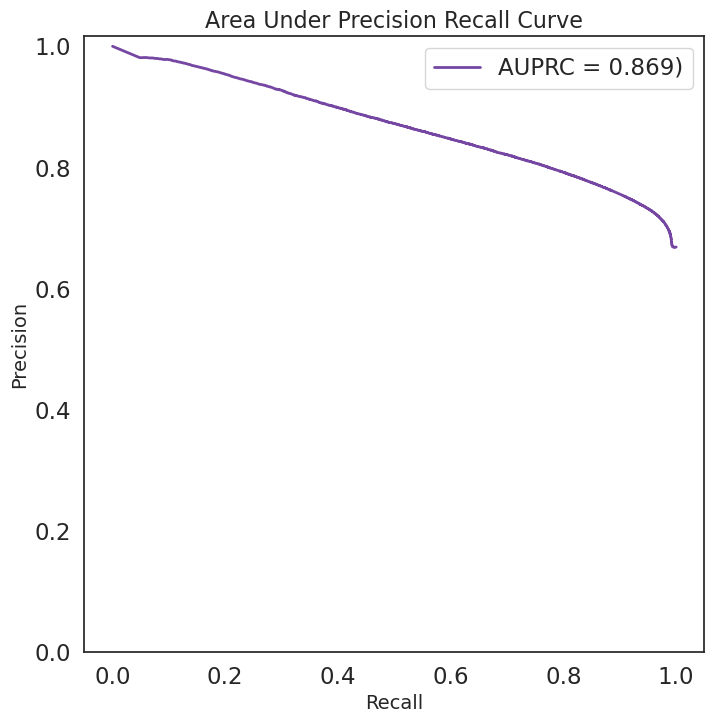

In [24]:
# Extract AUPRC & AP
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=2, alpha=0.9,
             label=f'AUPRC = {round(auprc, 3)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test_true, y_test_score)

In [25]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test_true, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.58      0.60      0.59     61872
     class 1       0.80      0.78      0.79    124881

    accuracy                           0.72    186753
   macro avg       0.69      0.69      0.69    186753
weighted avg       0.72      0.72      0.72    186753



In [26]:
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

array([[59.56975692, 40.43024308],
       [21.50767531, 78.49232469]])

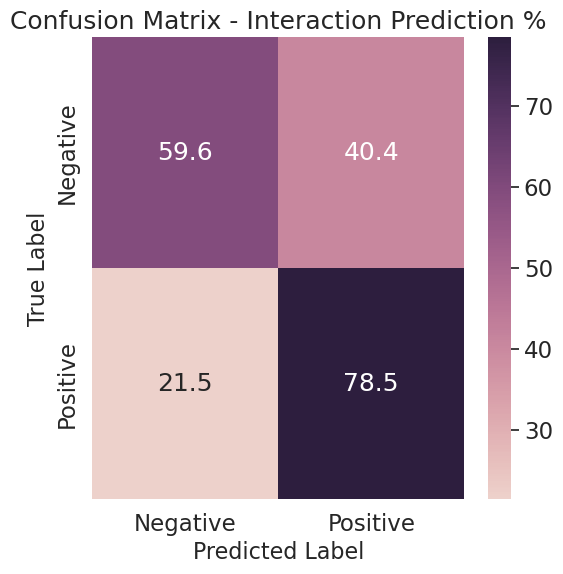

In [27]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=16)
    ax.set_ylabel("True Label", fontsize=16)
    ax.set_title("Confusion Matrix - Interaction Prediction %", fontsize=18)
    plt.show()

plot_conf_matrix_high(conf_matrix)